In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens='b'

In [2]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData/fromBooster/projectDataMigrating/NST_b-discNJN/data/'
data={}
for ens in enss:
    with h5py.File(f'{path}NST_b.h5_c{ens2label[ens]}') as f:
        t=(f['diags/N/data/N2_N2'][:,:,0]+f['diags/N/data/N2_N2'][:,:,1])/2
        data[ens]=yu.jackknife(np.real(t))
        # print(f['diags/N/opabs'][[0,1]])
        print(t.shape)

(743, 36)
(400, 40)
(494, 48)


In [3]:
ens='b'
def c2Hankle(c2pt,ts,shift=0):
    tmax=len(c2pt)-np.max(ts)*2 - shift
    return np.array([[[c2pt[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    
c2pt_jk=data[ens]
hankel=c2Hankle(c2pt_jk[0],[0,1,2,3],shift=1)
h0=hankel[0]
h1=hankel[1]
# print(h0)
# print(h1)

hh=np.linalg.inv(h0)@h1
evl,evt=np.linalg.eig(hh)

v_in=evt
zl_in=h0@v_in
zr_ni=np.linalg.inv(v_in)
an=zl_in[0,:]*zr_ni[:,0]
print(np.abs(an/h0[0,0]))

# print(evl[0])
# print(evt[:,0])

# print(np.linalg.eig(h1))

# print(hh@evt[:,0])

# print(np.conj(evt[:,0])@h1@evt[:,0])
# print(np.conj(evt[:,0])@h0@evt[:,0])
# print(evl[0]*np.conj(evt[:,0])@h0@evt[:,0])
# print(evl[1]*np.conj(evt[:,0])@h0@evt[:,0])
# print(np.conj(evt[:,0])@h1@evt[:,0]-evl[0]*np.conj(evt[:,0])@h0@evt[:,0])

[0.02406305 0.02406305 0.3996214  0.552316  ]


t_maxused=2
[[24.3194]]
[[13.503651]]
EigResult(eigenvalues=array([24.3194], dtype=float32), eigenvectors=array([[1.]], dtype=float32))
evl [0.55526245]
evect [1.]
0.55526245

t_maxused=4
[[24.3194    13.503651 ]
 [13.503651   7.9642158]]
[[13.503651   7.9642158]
 [ 7.9642158  4.932102 ]]
EigResult(eigenvalues=array([31.928562  ,  0.35505432], dtype=float32), eigenvectors=array([[ 0.87120706, -0.49091578],
       [ 0.49091578,  0.87120706]], dtype=float32))
evl [0.40820256 0.68560207]
evect [ 0.37792858 -0.9258348 ]
0.68560165

t_maxused=6
[[24.3194    13.503651   7.9642158]
 [13.503651   7.9642158  4.932102 ]
 [ 7.9642158  4.932102   3.14412  ]]
[[13.503651   7.9642158  4.932102 ]
 [ 7.9642158  4.932102   3.14412  ]
 [ 4.932102   3.14412    2.040162 ]]
EigResult(eigenvalues=array([ 3.4704704e+01,  7.3272306e-01, -9.6892603e-03], dtype=float32), eigenvectors=array([[-0.8336639 , -0.522579  ,  0.17864957],
       [-0.47343913,  0.5096832 , -0.718386  ],
       [-0.2843588 ,  0.68347216,

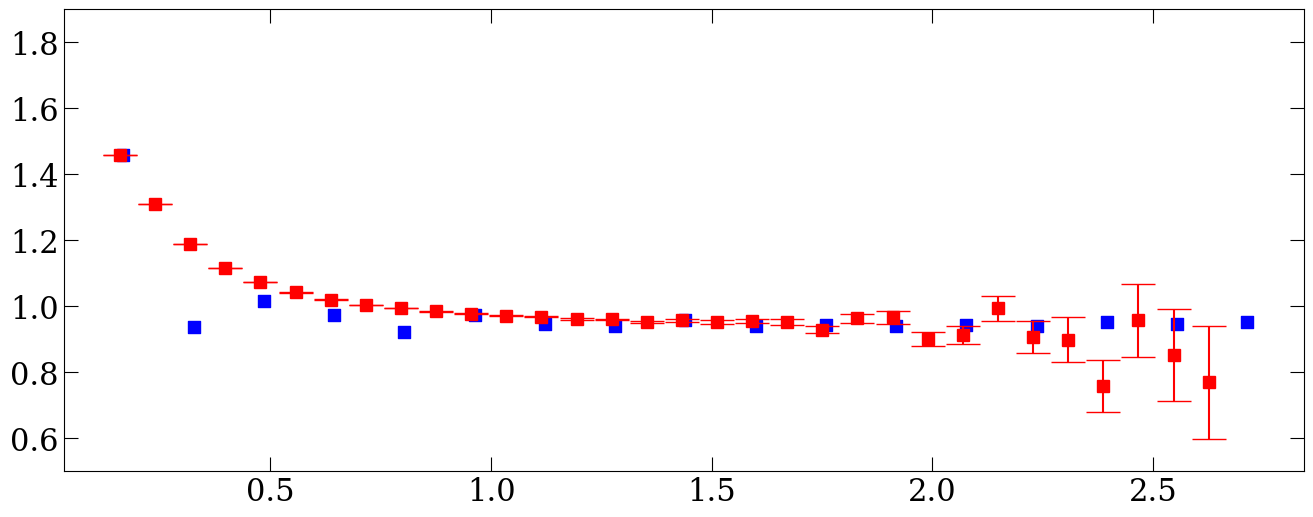

In [3]:
from scipy.linalg import solve_triangular,cholesky

def c2Hankle(c2pt,ts,shift=0):
    tmax=len(c2pt)-np.max(ts)*2 - shift
    return np.array([[[c2pt[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    

def run():
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fix, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
    ax=axs[0,0]
    ax.set_ylim([0.88,1.08])
    ax.set_ylim([0.5,1.9])
    
    c2pt_jk=data[ens]
    
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    tmin=1; tmax=32+1
    plt_x=(np.arange(tmin,tmax)+1)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_err,color='r',fmt='s')
    
    dt=1; shift=1
    epsilon_ZCW=1e-3
    def func(c):
        tt=[]
        for tsmax in range((len(c)-dt-shift)//2):
            # if not 0<tsmax<3:
            #     continue
            print(f't_maxused={tsmax*2+shift+dt}')
            t=c2Hankle(c,[ele for ele in range(tsmax+1)],shift=shift)
            h0=t[0]*1e9; h1=t[dt]*1e9
            t=np.linalg.inv(h0)@h1
            evl,evt=np.linalg.eig(t)
            print(h0)
            print(h1)
            print(np.linalg.eig(h0))
            print('evl',evl)
            evect=evt[:,-1]
            print('evect',evect)
            v1=evect@h1@evect;v0=evect@h0@evect
            print(v1/v0)
            
            if tsmax==2:
                evect=[0.3779285, -0.9258348, 0]
                v1=evect@h1@evect;v0=evect@h0@evect
                print(v1/v0)
            
            ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
            t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
            # print(tsmax*2+shift+dt,t)
            t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
            # print(tsmax*2+shift+dt,t)
            t=np.max(np.real(t)) if len(t)!=0 else np.nan
            t=-np.log(t)/dt
            tt.append(t)
            print()

        return np.array(tt)
    res=func(np.mean(c2pt_jk,axis=0))
    plt_x=(np.arange(len(res))*2+shift+dt+0.1)*xunit; plt_y=res*yunit
    ax.scatter(plt_x,plt_y,color='b',marker='s')

for ens in enss[:1]:
    run()

In [54]:
def c2Hankel(c2pt,ts,shift=0):
    tmax=len(c2pt)-np.max(ts)*2 - shift
    return np.array([[[c2pt[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    

ens='b'
c2pt_jk=data[ens]
def func(c2pt):
    hankel=c2Hankel(c2pt,[0,1,2],shift=1)
    h0=hankel[0]; h1=hankel[1]
    # t=np.linalg.inv(h0)@h1
    evl,evt=np.linalg.eig(h0)    
    print(evl)
    # return evt[:,0]
evect=func(c2pt_jk[0])
    

[ 3.4704225e-08  7.3268652e-10 -9.6679886e-12]


[4.05190436e-01 1.01966256e-08 1.51940637e-04 1.19676687e+00
 5.71126210e-01 2.44223494e+00]
74.72315284430401 0 inf
74.71774896858776
74.7674082595588


/tmp/ipykernel_212182/3980054940.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  print(np.mean(chi2_jk),Ndof,np.mean(chi2_jk)/Ndof)


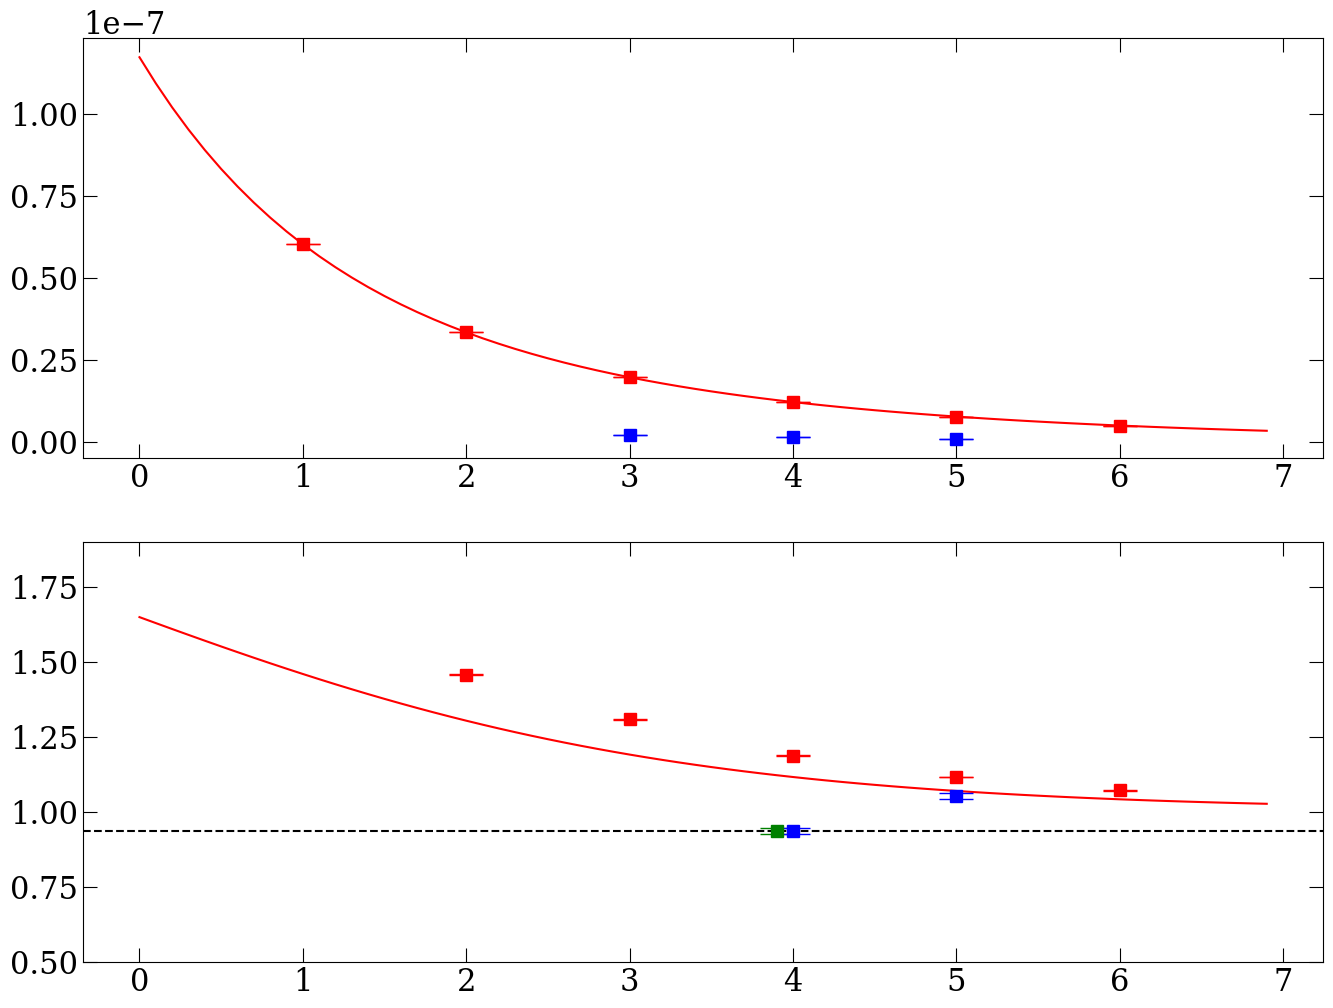

In [78]:
def c2Hankle(c2pt,ts,shift=0):
    tmax=len(c2pt)-np.max(ts)*2 - shift
    return np.array([[[c2pt[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    

res=None
def run():
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    xunit=1
    fix, axs = yu.getFigAxs(2,1,Lrow=6,Lcol=16)
    ax=axs[1,0]
    # ax.set_ylim([0.88,1.08])
    ax.set_ylim([0.5,1.9])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    
    c2pt_jk=data[ens]
    
    mean,err=yu.jackme(c2pt_jk)
    tmin=1; tmax=6+1
    plt_x=(np.arange(tmin,tmax))*xunit; plt_y=mean[tmin:tmax]*yunit; plt_err=err[tmin:tmax]*yunit
    axs[0,0].errorbar(plt_x,plt_y,plt_err,color='r',fmt='s')
    # axs[0,0].set_yscale('log')    
    
    tList=np.arange(1,6+1)
    # baseFunc=lambda ts,m,c0,dE1,rc1: c0*np.exp(-m*ts)*(1+rc1*np.exp(-dE1*ts))
    baseFunc=lambda ts,m,c0,dE1,rc1,dE2,rc2: np.abs(c0)*np.exp(-np.abs(m)*ts)*(1+np.abs(rc1)*np.exp(-np.abs(dE1)*ts)+np.abs(rc2)*np.exp(-np.abs(dE1)*ts-np.abs(dE2)*ts))
    # baseFunc=lambda ts,m,c0,dE1,rc1,dE2,rc2: np.abs(c0)*np.exp(-np.abs(m)*ts)*(1+np.abs(rc1)*np.exp(-np.abs(dE1)*ts)+np.abs(rc2)*np.exp(-np.abs(dE1)*ts-np.abs(dE2)*ts))
    def fitfunc(pars):
        return baseFunc(tList,*pars)
    y_jk=c2pt_jk[:,tList]
    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0=[4.05273387e-01, 2.23996424e-08, 5.71193430e-01, 5.04143248e-01])
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0=[0.3, 1e-08, 0.5, 1, 1, 1])
    pars0=np.mean(pars_jk,axis=0)
    print(pars0)
    print(np.mean(chi2_jk),Ndof,np.mean(chi2_jk)/Ndof)
    
    # pars0=[4.05273389e-01, 2.23996426e-08, 5.71196351e-01, 1.11173803]
    mean,err,cov=yu.jackmec(y_jk)
    diff=fitfunc(pars0)-mean
    chi2=diff@np.linalg.inv(cov)@diff
    print(chi2)
    
    tList_plt=np.arange(0,7,0.1)
    plt_y=baseFunc(tList_plt,*pars0)*yunit
    axs[0,0].plot(tList_plt,plt_y,'r-')
    
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    tmin=1; tmax=5+1
    plt_x=(np.arange(tmin,tmax)+1)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_err,color='r',fmt='s')    
    
    mean,err,cov=yu.jackmec(mEff_jk[:,1:6])
    diff=np.log(baseFunc(tList,*pars0)/baseFunc(tList+1,*pars0))[:-1]-mean
    chi2=diff@np.linalg.inv(cov)@diff
    print(chi2)
    
    tList_plt=np.arange(0,7,0.1)
    plt_y=np.log(baseFunc(tList_plt,*pars0)/baseFunc(tList_plt+1,*pars0))*yunit
    ax.plot(tList_plt,plt_y,'r-')    

    ts=[0,1]
    dt=1; shift=1
    epsilon_ZCW=0.
    def func(c):
        t=c2Hankle(c,ts,shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        t=np.max(np.real(t)) if len(t)!=0 else np.nan
        t=-np.log(t)/dt
        return [t]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(4-0.1)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='g',mfc=None)
    
    def func(c):
        t=c2Hankle(c,ts,shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        ind=np.argmax(np.real(t))
        evect=evt[:,ind]
        t=(evect@h1@evect)/(evect@h0@evect)
        return evt[:,ind]
    evect=func(np.mean(c2pt_jk,axis=0))
    # print(evect)
    def func(c):
        hankel=c2Hankle(c,ts,shift=shift)
        t=np.real(np.einsum('i,tij,j->t',np.conj(evect),hankel,evect))
        t=-np.log(t/np.roll(t,1))
        return t[1:2+1]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(np.arange(len(mean))+4)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='b',mfc=None)
    
    def func(c):
        hankel=c2Hankle(c,ts,shift=shift)
        t=np.real(np.einsum('i,tij,j->t',np.conj(evect),hankel,evect))
        return t[:]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    tmin=0; tmax=2+1
    plt_x=(np.arange(tmin,tmax)+3)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_err=err[tmin:tmax]*yunit
    axs[0,0].errorbar(plt_x,plt_y,plt_err,color='b',fmt='s')
    # axs[0,0].set_ylim([5*1e-10,5*1e-9])

for ens in enss[:1]:
    run()

[ -1.5114278    1.458769     1.3092223    1.1881963    1.1163828
   1.0724282    1.0418257    1.0196247    1.0038756    0.99475133
   0.9844583    0.9767879    0.97097695   0.9677786    0.9606806
   0.95966125   0.951882     0.9567468    0.95161813   0.9547573
   0.95182586   0.9291488    0.96329117   0.9656756    0.9005945
   0.9131243    0.99285847   0.9064842    0.8987127    0.7570235
   0.9578657    0.85233116   0.7691375    0.92781824   1.2476472
 -32.262527  ]
[ 0.3779285 -0.9258348]


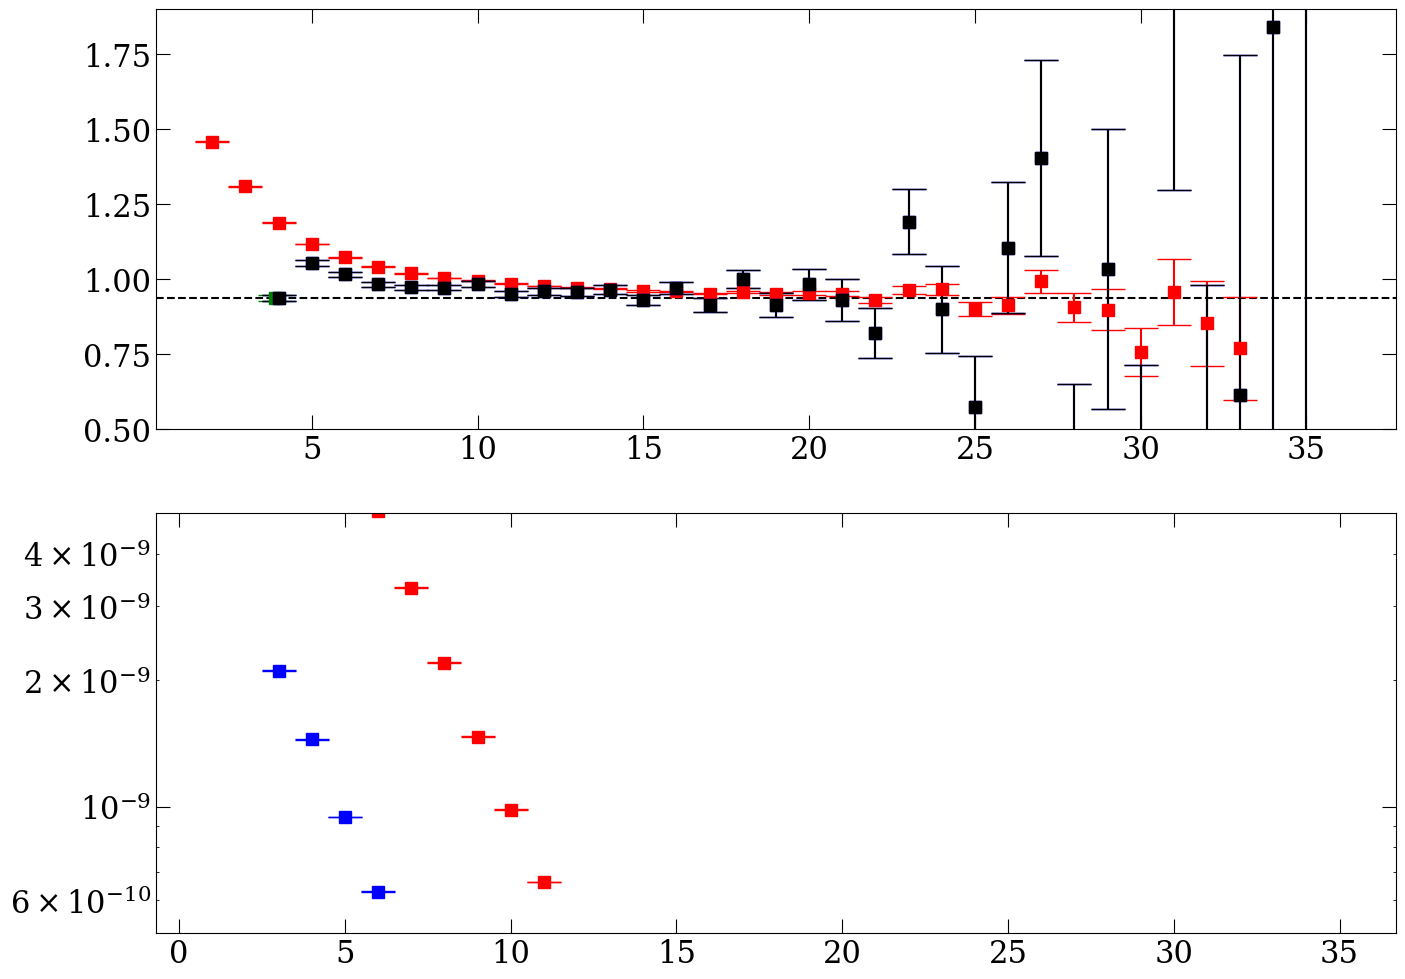

In [22]:
def c2Hankle(c2pt,ts,shift=0):
    tmax=len(c2pt)-np.max(ts)*2 - shift
    return np.array([[[c2pt[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    

res=None
def run():
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    xunit=1
    fix, axs = yu.getFigAxs(2,1,Lrow=6,Lcol=16)
    ax=axs[0,0]
    # ax.set_ylim([0.88,1.08])
    ax.set_ylim([0.5,1.9])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    
    c2pt_jk=data[ens]
    
    mean,err=yu.jackme(c2pt_jk)
    tmin=1; tmax=32+1
    plt_x=(np.arange(tmin,tmax))*xunit; plt_y=mean[tmin:tmax]*yunit; plt_err=err[tmin:tmax]*yunit
    axs[1,0].errorbar(plt_x,plt_y,plt_err,color='r',fmt='s')
    axs[1,0].set_yscale('log')    
    
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    print(mEff_mean*yunit)
    tmin=1; tmax=32+1
    plt_x=(np.arange(tmin,tmax)+1)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_err,color='r',fmt='s')    
    
    
    
    # plt_x=(tF[:,0]*2-1+0.1)*xunit; plt_y=tF[:,1]*yunit; plt_err=tF[:,2]*yunit
    # ax.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')
    
    ts=[0,1]
    dt=1; shift=1
    epsilon_ZCW=0.
    def func(c):
        t=c2Hankle(c,ts,shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        t=np.max(np.real(t)) if len(t)!=0 else np.nan
        t=-np.log(t)/dt
        return [t]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(4-0.1)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='g',mfc=None)
    
    def func(c):
        t=c2Hankle(c,ts,shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        ind=np.argmax(np.real(t))
        evect=evt[:,ind]
        t=(evect@h1@evect)/(evect@h0@evect)
        return evt[:,ind]
    evect=func(np.mean(c2pt_jk,axis=0))
    print(evect)
    def func(c):
        hankel=c2Hankle(c,ts,shift=shift)
        t=np.real(np.einsum('i,tij,j->t',np.conj(evect),hankel,evect))
        t=-np.log(t/np.roll(t,1))
        return t[1:]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(np.arange(len(mean))+4)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='b',mfc=None)
    
    def func(c):
        hankel=c2Hankle(c,ts,shift=shift)
        t=np.real(np.einsum('i,tij,j->t',np.conj(evect),hankel,evect))
        return t[:]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    tmin=0; tmax=32+1
    plt_x=(np.arange(tmin,tmax)+3)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_err=err[tmin:tmax]*yunit
    axs[1,0].errorbar(plt_x,plt_y,plt_err,color='b',fmt='s')
    axs[1,0].set_ylim([5*1e-10,5*1e-9])
    
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    t=yu.jackmap(func,t)
    mean,err=yu.jackme(t)
    plt_x=(np.arange(len(mean))+4)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='black',mfc=None)
    
for ens in enss[:1]:
    run()

In [81]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/temp/temp'
with open(path,'r') as f:
    tF=f.read().split('\n')
tF=np.array([[float(ele) for ele in row.split(' ')[1:-1]] for row in tF])

[ 0.18421753 -0.52520794  0.8307951 ]
[35.532757] [154.82037]
[[2.4319402e-08 1.3503651e-08]
 [1.3503651e-08 7.9642160e-09]]
[3.1928561e-08 3.5505468e-10]
[[1.3503651e-08 7.9642160e-09]
 [7.9642160e-09 4.9321023e-09]]
[1.8262023e-08 1.7372941e-10]
[0.4082044  0.68560135]
[[-0.5654639  0.3779285]
 [ 0.8247731 -0.9258348]]
[0.4082044  0.68560135]
0.68560135


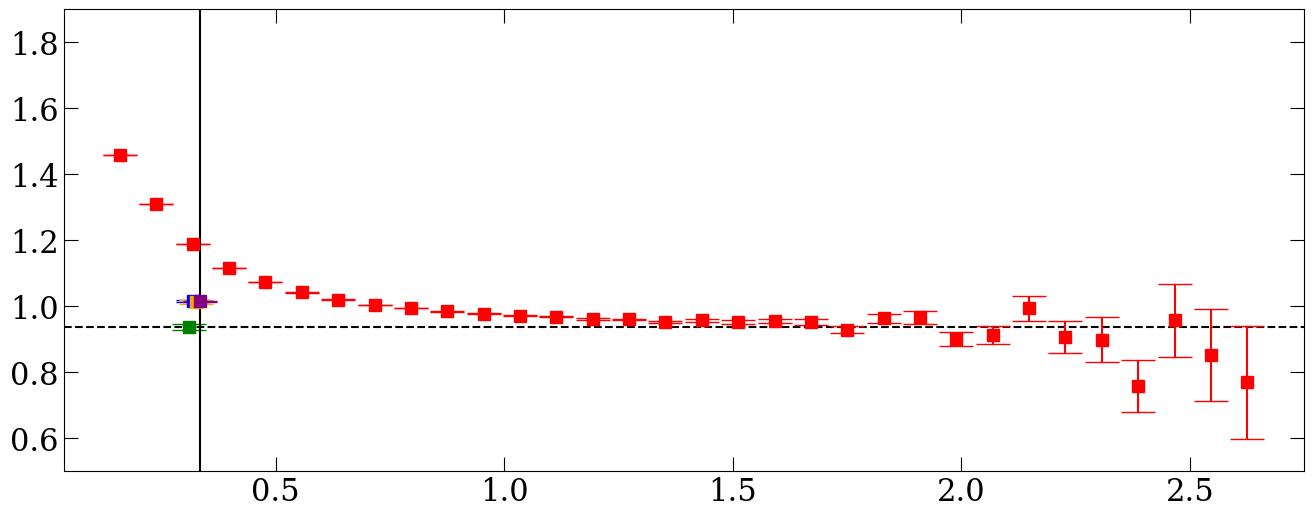

In [26]:
def c2Hankle(c2pt,ts,shift=0):
    tmax=len(c2pt)-np.max(ts)*2 - shift
    return np.array([[[c2pt[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    

res=None
def run():
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fix, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
    ax=axs[0,0]
    # ax.set_ylim([0.88,1.08])
    ax.set_ylim([0.5,1.9])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    
    c2pt_jk=data[ens]
    
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    tmin=1; tmax=32+1
    plt_x=(np.arange(tmin,tmax)+1)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_err,color='r',fmt='s')    
    
    # plt_x=(tF[:,0]*2-1+0.1)*xunit; plt_y=tF[:,1]*yunit; plt_err=tF[:,2]*yunit
    # ax.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')
    
    dt=1; shift=1
    epsilon_ZCW=0.
    def func(c):
        t=c2Hankle(c,[0,1],shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        t=np.max(np.real(t)) if len(t)!=0 else np.nan
        t=-np.log(t)/dt
        return [t]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(4-0.1)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='g',mfc=None)
    
    dt=1; shift=1
    def func(c):
        t=c2Hankle(c,[0,1,2],shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        t=np.max(np.real(t)) if len(t)!=0 else np.nan
        t=-np.log(t)/dt
        return [t]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(4)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='b',mfc=None)
    
    dt=1; shift=1
    def func(c):
        t=c2Hankle(c,[1,2],shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        t=np.max(np.real(t)) if len(t)!=0 else np.nan
        t=-np.log(t)/dt
        return [t]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(4+0.1)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='orange',mfc=None)
    
    dt=1; shift=1
    def func(c):
        t=c2Hankle(c,[0,2],shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        t=np.max(np.real(t)) if len(t)!=0 else np.nan
        t=-np.log(t)/dt
        return [t]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(4+0.2)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='purple',mfc=None)
    
    dt=1; shift=1
    def func(c):
        t=c2Hankle(c,[0,1,4],shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        ind=np.argmax(np.real(t))
        return evt[:,ind]
    evect=func(np.mean(c2pt_jk,axis=0))
    print(evect)
    def func(c):
        t=c2Hankle(c,[0,1,4],shift=shift)
        h0=t[0]; h1=t[dt]
        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        # ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        # t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5]
        # # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        # t=np.max(np.real(t)) if len(t)!=0 else np.nan
        # t=-np.log(t)/dt
        
        t=(evect@h1@evect)/(evect@h0@evect)
        return [t]
    t=yu.jackmap(func,c2pt_jk)
    mean,err=yu.jackme(t)
    print(mean,err)
    plt_x=(4+0.2)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='black',mfc=None)

    dt=1; shift=1
    res=[]
    def func(c):
        t=c2Hankle(c,[0,1],shift=shift)
        h0=t[0]; h1=t[dt]
        
        evl,evt=np.linalg.eig(h0)
        print(h0)
        print(evl)
        evl,evt=np.linalg.eig(h1)
        print(h1)
        print(evl)

        t=np.linalg.inv(h0[:2,:2])@h1[:2,:2]
        evl,evt=np.linalg.eig(t)
        print(evl)
        print(evt)

        t=np.linalg.inv(h0)@h1
        evl,evt=np.linalg.eig(t)
        print(evl)
        
        
        
        res.append(evl)
        ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
        t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
        # t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
        t=np.max(np.real(t)) if len(t)!=0 else np.nan
        print(t)
        t=-np.log(t)/dt
        return [t]
    func(np.mean(c2pt_jk,axis=0))


for ens in enss[:1]:
    run()

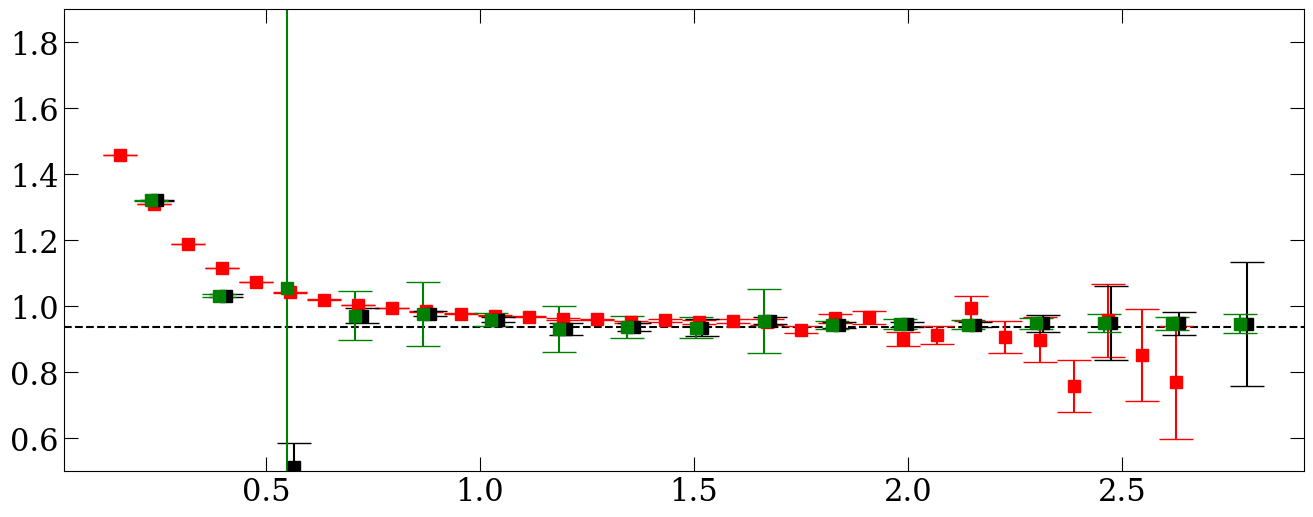

In [82]:
def c2Hankle(c2pt,ts,shift=0):
    tmax=len(c2pt)-np.max(ts)*2 - shift
    return np.array([[[c2pt[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    

res=None
def run():
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fix, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
    ax=axs[0,0]
    ax.set_ylim([0.88,1.08])
    ax.set_ylim([0.5,1.9])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    
    c2pt_jk=data[ens]
    
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,c2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    tmin=1; tmax=32+1
    plt_x=(np.arange(tmin,tmax)+1)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_err,color='r',fmt='s')
    
    
    plt_x=(tF[:,0]*2-1+0.1)*xunit; plt_y=tF[:,1]*yunit; plt_err=tF[:,2]*yunit
    ax.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')
    
    dt=1; shift=0
    
    # epsilon_ZCW=0.
    # def func(c):
    #     tt=[]
    #     for tsmax in range((len(c)-dt-shift)//2):
    #         t=c2Hankle(c,range(tsmax+1),shift=shift)
    #         h0=t[0]; h1=t[dt]
    #         t=np.linalg.inv(h0)@h1
    #         evl,evt=np.linalg.eig(t)
    #         ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
    #         t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
    #         # t=[ele for ele in t if np.imag(ele)==0 and np.real(ele)<1]
    #         t=np.max(np.real(t)) if len(t)!=0 else np.nan
    #         t=-np.log(t)/dt
    #         tt.append(t)
    #     return np.array(tt)
    # t=yu.jackmap(func,c2pt_jk)
    # # global res
    # # res=t
    # mean,err=yu.jackme(t)
    # plt_x=(np.arange(len(mean))*2+shift+dt-0.1)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    # ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='g',mfc=None)
    
    # epsilon_ZCW=0.
    # def func(c):
    #     tt=[]
    #     for tsmax in range((len(c)-dt-shift)//2):
    #         t=c2Hankle(c,range(tsmax+1),shift=shift)
    #         h0=t[0]; h1=t[dt]
    #         t=np.linalg.inv(h0)@h1
    #         evl,evt=np.linalg.eig(t)
    #         ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
    #         t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
    #         t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
    #         t=np.max(np.real(t)) if len(t)!=0 else np.nan
    #         t=-np.log(t)/dt
    #         tt.append(t)
    #     return np.array(tt)
    # t=yu.jackmap(func,c2pt_jk)
    # mean,err=yu.jackme(t)
    # plt_x=(np.arange(len(mean))*2+shift+dt+0.1)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    # ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='b',mfc=None)
    
    epsilon_ZCW=0.1
    def func(c):
        tt=[]
        for tsmax in range((len(c)-dt-shift+1)//2):
            t=c2Hankle(c,range(tsmax+1),shift=shift)
            h0=t[0]; h1=t[dt]
            t=np.linalg.inv(h0)@h1
            evl,evt=np.linalg.eig(t)
            ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
            t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
            t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
            t=np.max(np.real(t)) if len(t)!=0 else np.nan
            t=-np.log(t)/dt
            tt.append(t)
        return np.array(tt)
    t=yu.jackmap(func,c2pt_jk)
    global res
    res=t
    mean,err=yu.jackme(t)
    plt_x=(np.arange(len(mean))*2+shift+dt-0.1)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='g',mfc=None)
    

    # def func(c):
    #     tt={}
    #     for tsmax in range((len(c)-dt-shift)//2):
    #         t=c2Hankle(c,range(tsmax+1),shift=shift)
    #         h0=t[0]; h1=t[dt]
    #         t=np.linalg.inv(h0)@h1
    #         evl,evt=np.linalg.eig(t)
    #         ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
    #         t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
    #         t=[ele for ele in t if np.abs(np.imag(ele)/ele)<1e-5 and 0<np.real(ele)<1]
    #         t=np.max(np.real(t)) if len(t)!=0 else np.nan
    #         ind=0
    #         for i,ele in enumerate(evl):
    #             if ele==t:
    #                 ind=i
    #                 break
    #         tt[tsmax]=evt[:,ind]
    #     return tt
    # evts=func(np.mean(c2pt_jk,axis=0))    
    # def func(c):
    #     tt=[]
    #     for tsmax in range((len(c)-dt-shift)//2):
    #         t=c2Hankle(c,range(tsmax+1),shift=shift)
    #         h0=t[0]; h1=t[dt]
    #         evect=evts[tsmax]
    #         t=np.real(np.conj(evect)@h1@evect)/np.real(np.conj(evect)@h0@evect)
    #         t=-np.log(t)/dt
    #         tt.append(t)
    #     return np.array(tt)
    # t=yu.jackmap(func,c2pt_jk)
    # mean,err=yu.jackme(t)
    # plt_x=(np.arange(len(mean))*2+shift+dt+0.3)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    # ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='b',mfc=None)
    
    
    # colors=['r','g','b']
    # for i,ts in enumerate([[0],[0,2],[0,2,4]]):
    #     t0,t=3,6
    #     hankel=c2Hankle(np.mean(c2pt_jk,axis=0),ts)[1:]
    #     evals,evecs = yu.GEVP(hankel,t0,tList=[t])
    #     evec=evecs[0,0:1]
    #     evec=evec/np.linalg.norm(evec)
    #     print(evec)
    #     def func(c2pt):
    #         hankel=c2Hankle(c2pt,ts)[1:]
    #         c=np.real((np.conj(evec)@hankel@evec.T)[:,0,0])
    #         meff=np.log(c/np.roll(c,-1))
    #         return meff
        
    #     # t0=1
    #     # def func(c2pt):
    #     #     hankel=c2Hankle(c2pt,ts)[1:]
    #     #     evals,evecs = yu.GEVP(hankel,t0)
    #     #     meff=np.log(evals/np.roll(evals,-1,axis=0))[:,0]
    #     #     return meff
        
    #     meff_jk=yu.jackmap(func,c2pt_jk)
    #     mean,err=yu.jackme(meff_jk)
    #     t_maxused=np.array([2*np.max(ts)+t+1 for t in range(1,len(mean)+1)])
    #     plt_x=t_maxused*xunit; plt_y=mean*yunit; plt_err=err*yunit
    #     ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=colors[i],mfc=None)

for ens in enss[:1]:
    run()

[3.78586087e-01 1.55169822e-08 1.75839389e-01 7.12656172e-01
 7.46614933e-01 4.33587603e+00 1.20000000e+00 1.00000000e+00]
[ 3.82798416e-01  1.71009112e-08  2.50414524e-01  8.06725885e-01
  9.58035578e+00 -5.97204629e+02  8.70110504e-01  1.18882797e+00]


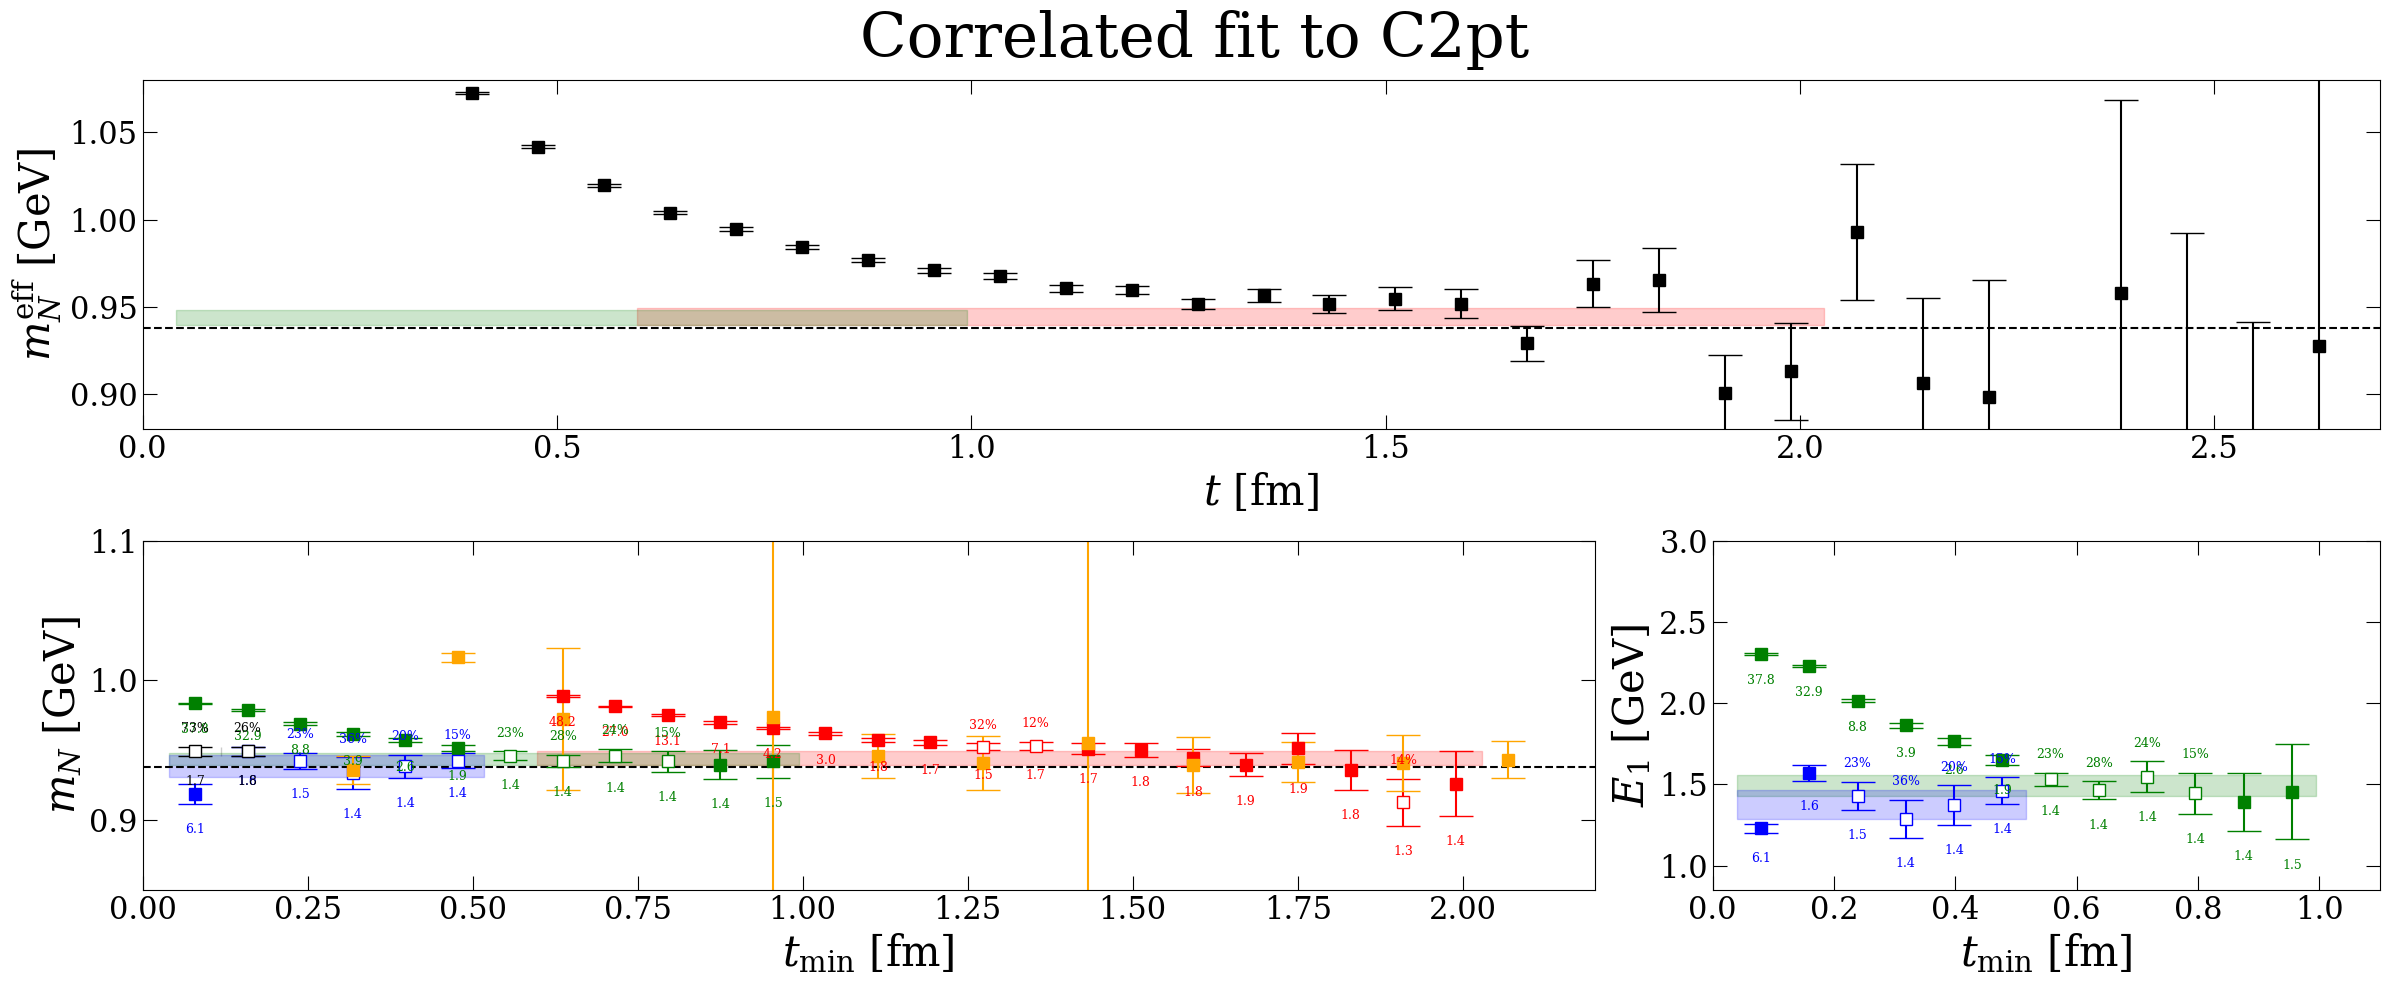

In [68]:
def c2Hankle(c,ts,shift=0):
    tmax=len(c)-np.max(ts)*2 - shift
    return np.array([[[c[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    

propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_C2pt_4st=lambda t,E0,c0,dE1,rc1,dE2,rc2,dE3,rc3: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t) + rc3*np.exp(-dE3*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(corrQ=False,meffQ=True,pdf=None):
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    if meffQ:
        fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    else:
        fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    # ax2.set_ylim([0.8,1.2])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=data[ens]
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1,1.2,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    ax1.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2)
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    ax1.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 4st fits
    color='black'
    fitmins=settings['fitmins_4st']
    pars0=np.hstack([pars0,pars0_initial[6-DNpar:8-DNpar]])
    print(pars0)
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return None
                # return func_mEff_4st(tList,*pars)
            return func_C2pt_4st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        # fits_all.append([('4st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
        if fitmin==1:
            print(pars0)
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{4st}}=$'+yu.un2str(plt_y,plt_err)) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')

    # color='orange'
    # pars_jk,props_jk=yu.jackMA(fits_all)
    # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # pars_mean,pars_err=yu.jackme(pars_jk)
    # plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    # ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    # ax2.legend(loc=(0.6,0.5),fontsize=12)
    # ax3.legend(fontsize=12)
    
    # tmaxused=range(1,len(C2pt_jk[0])+1)
    
    dt=1; shift=1; epsilon_ZCW=0.1
    def func(c):
        tt=[]
        for tsmax in range((len(c)-dt-shift)//2):
            t=c2Hankle(c,range(tsmax+1),shift=shift)
            h0=t[0]; h1=t[dt]
            t=np.linalg.inv(h0)@h1
            evl,evt=np.linalg.eig(t)
            ZCWn=np.abs(np.atleast_2d(h0@evt)[0,:]*(np.atleast_2d(np.linalg.inv(evt))[:,0])/(h0[0,0]))
            t=[e for e,z in zip(evl,ZCWn) if z>epsilon_ZCW]
            t=[ele for ele in t if np.imag(ele)==0 and np.real(ele)<1]
            t=np.max(np.real(t)) if len(t)!=0 else np.nan
            t=-np.log(t)/dt
            tt.append(t)
        return np.array(tt)
    
    t=yu.jackmap(func,C2pt_jk)
    mean,err=yu.jackme(t)
    plt_x=(np.arange(len(mean))*2+shift+dt)*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color='orange',mfc=None)
    
    plt.tight_layout()
    # if pdf!=None:
    #     pdf.savefig(fig)
    # else:
    #     if meffQ:
    #         plt.savefig('fig/fit_meff_cor.pdf' if corrQ else 'fig/fit_meff_unc.pdf')
    #     else:
    #         plt.savefig('fig/fit_2pt_cor.pdf' if corrQ else 'fig/fit_2pt_unc.pdf')
    # plt.close()
    # return res

for ens in enss[:1]:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,25+1),
            'fitmins_2st':range(1,12+1),
            'fitmins_3st':range(1,6+1),
            'fitmins_4st':[2,1],
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,18+1),
            'fitmins_3st':range(1,8+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,21+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    # res2pt={}
    # import matplotlib.backends.backend_pdf
    # pdf = matplotlib.backends.backend_pdf.PdfPages(f"fig/fit2pt_{ens}.pdf")
    # res2pt[(True,True)]=run(True,True,pdf=pdf)
    # res2pt[(True,False)]=run(True,False,pdf=pdf)
    # res2pt[(False,True)]=run(False,True,pdf=pdf)
    # res2pt[(False,False)]=run(False,False,pdf=pdf)
    # pdf.close()
    
    run(True,False)

In [ ]:
propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(corrQ=False,meffQ=True,pdf=None):
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    if meffQ:
        fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    else:
        fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=data[ens]
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    color='orange'
    pars_jk,props_jk=yu.jackMA(fits_all)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    ax2.legend(loc=(0.6,0.5),fontsize=12)
    ax3.legend(fontsize=12)
    
    plt.tight_layout()
    if pdf!=None:
        pdf.savefig(fig)
    else:
        if meffQ:
            plt.savefig('fig/fit_meff_cor.pdf' if corrQ else 'fig/fit_meff_unc.pdf')
        else:
            plt.savefig('fig/fit_2pt_cor.pdf' if corrQ else 'fig/fit_2pt_unc.pdf')
    plt.close()
    return res

for ens in enss[:]:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,25+1),
            'fitmins_2st':range(1,12+1),
            'fitmins_3st':range(1,6+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,18+1),
            'fitmins_3st':range(1,8+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,21+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    res2pt={}
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"fig/fit2pt_{ens}.pdf")
    res2pt[(True,True)]=run(True,True,pdf=pdf)
    res2pt[(True,False)]=run(True,False,pdf=pdf)
    res2pt[(False,True)]=run(False,True,pdf=pdf)
    res2pt[(False,False)]=run(False,False,pdf=pdf)
    pdf.close()

/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/01_Nsgm/util.py:106: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  pars=leastsq(fitfunc_wrapper2,pars_mean)[0]
/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/01_Nsgm/util.py:106: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  pars=leastsq(fitfunc_wrapper2,pars_mean)[0]
/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/01_Nsgm/util.py:106: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  pars=leastsq(fitfunc_wrapper2,pars_mean)[0]
/tmp/ipykernel_196706/3261827576.py:9: RuntimeWarning: overflow encountered in exp
  func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
/tmp/ipykernel_196706/3261827576.py:9: RuntimeWarning: overflow encountered in multiply
  func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
